In [236]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities_v3 import *

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [237]:
#chas_test = np.load("test_signal.npy")

In [238]:
x_sep = 13.9#10.39
height_sep=-15.5#-15.7
stroke=-202
frequency=3
lambda_val=9.74#20
axis="z"
offset_y=+4.9
yuk_or_grav="yuk"
alpha=1
bead_size=7.6
signal_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)

Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force


In [239]:
# shift phase of signal according to TF
# data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]
# how is the phase shift defined

# convert to bits, this works only for one second chunk!
# data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

extrapol_f = 0
TF_phase_shift = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]+[0.07]*extrapol_f
harmonics = np.arange(3,len(TF_phase_shift)*3+3,3)

print(len(TF_phase_shift))
TF_phase_shift_norm = [1*np.random.normal(TF_phase_shift[i],TF_phase_shift[i]/20) for i in range(len(TF_phase_shift))]
# 7 charges outdated
#amplitude_scale =[1.94E-17,1.09E-17,8.45E-18,7.89E-18,7.63E-18,7.92E-18,7.93E-18,8.39E-18,8.01E-18,6.06E-18,6.76E-18,5.73E-18,6.33E-18]+[8.88e-18]*extrapol_f
# 6 charges new
amplitude_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]

fft_sim = np.fft.rfft(signal_sim[1]) 
new_fft_sim = fft_sim.copy()
new_fft_shift_only = fft_sim.copy()
new_fft_sim[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim[0])
for harmonic in harmonics:
    new_fft_shift_only[harmonic] = np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))
    new_fft_sim[harmonic] = 1/amplitude_scale[harmonic//3-1] * np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))

signal_sim_shift=np.fft.irfft(new_fft_shift_only) 
signal_sim_shift_scale =np.fft.irfft(new_fft_sim) 
    

13


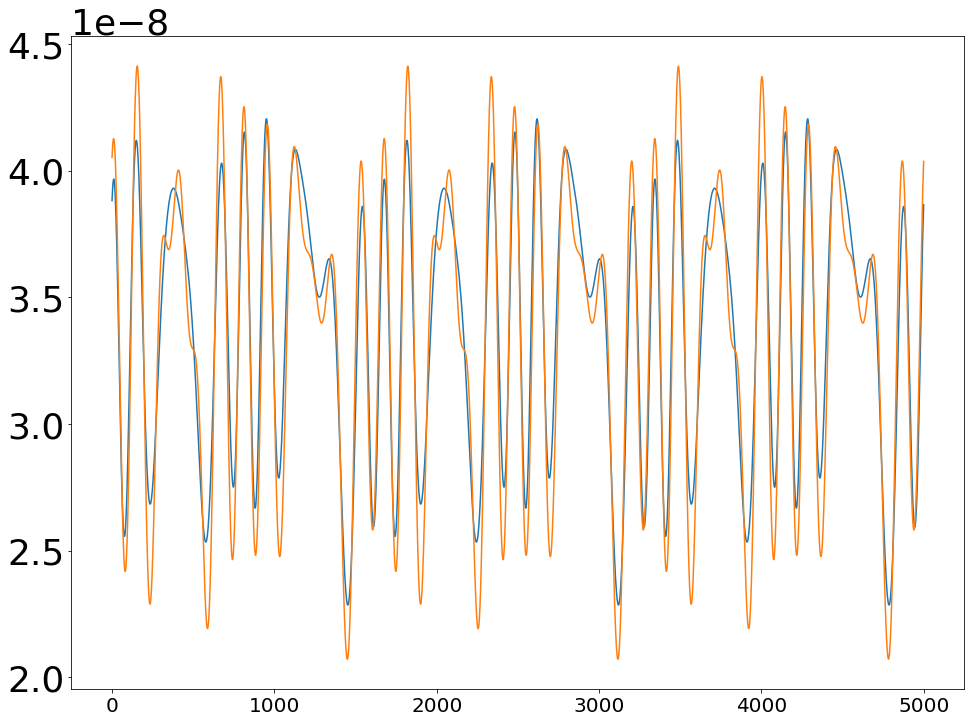

In [240]:
plt.plot(signal_sim_shift/1.05e-17)
plt.plot(signal_sim_shift_scale)
#plt.yscale("log")
#plt.xlim(0,100)

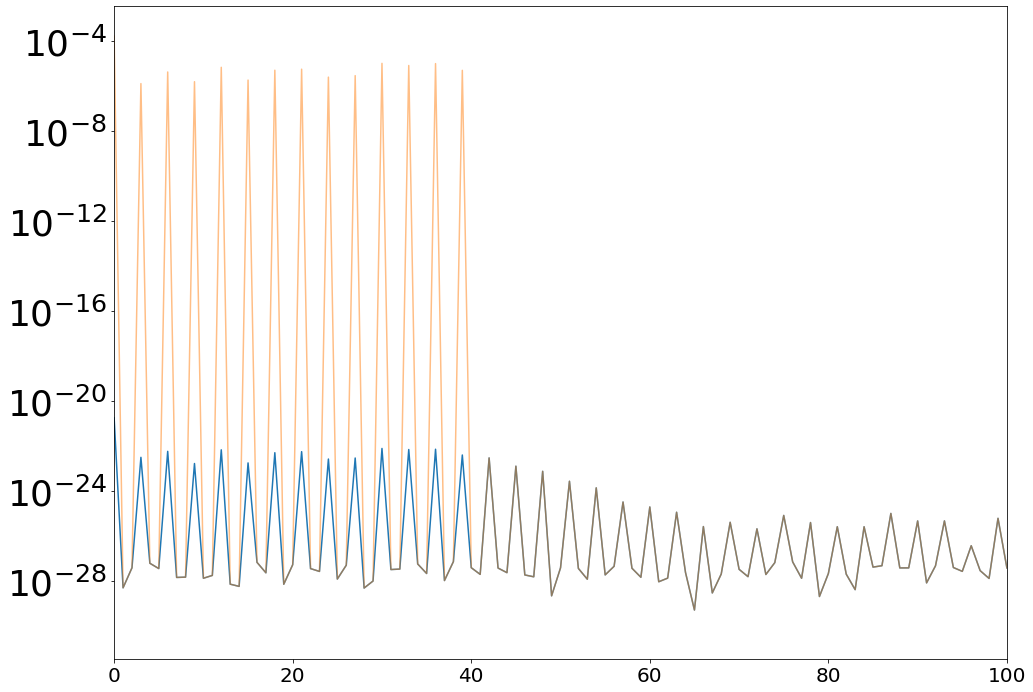

(0.0, 40.0)

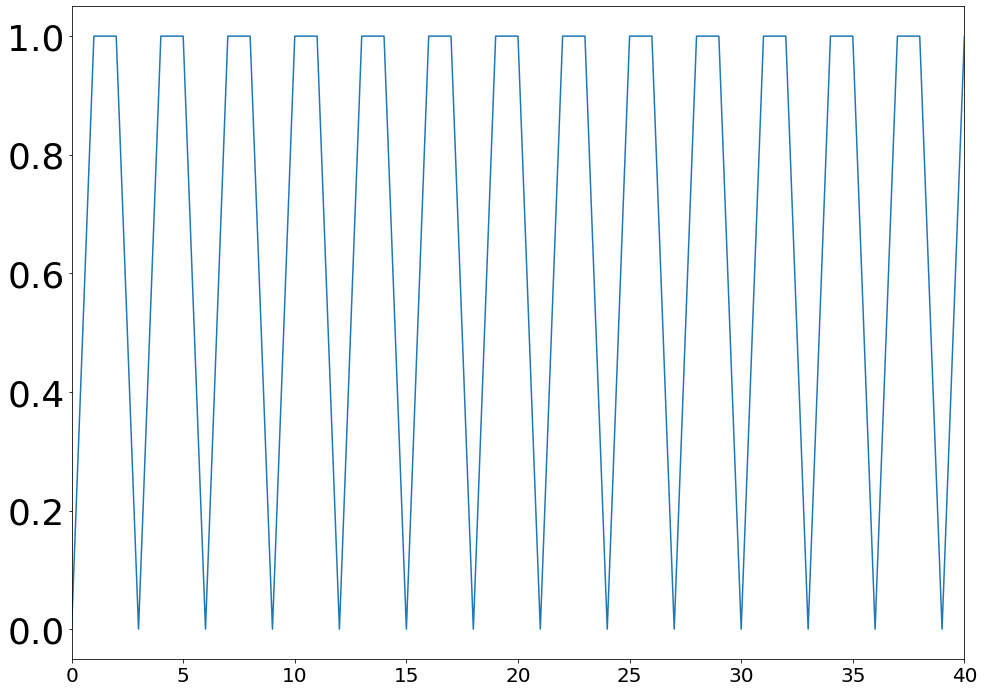

In [241]:
plt.plot(np.abs(fft_sim))
plt.plot(np.abs(new_fft_sim),alpha=0.5)
plt.yscale("log")
plt.xlim(0,100)
plt.show()
plt.plot(np.abs(fft_sim)/np.abs(new_fft_sim))
plt.xlim(0,40)
#plt.ylim(0.995,1.005)



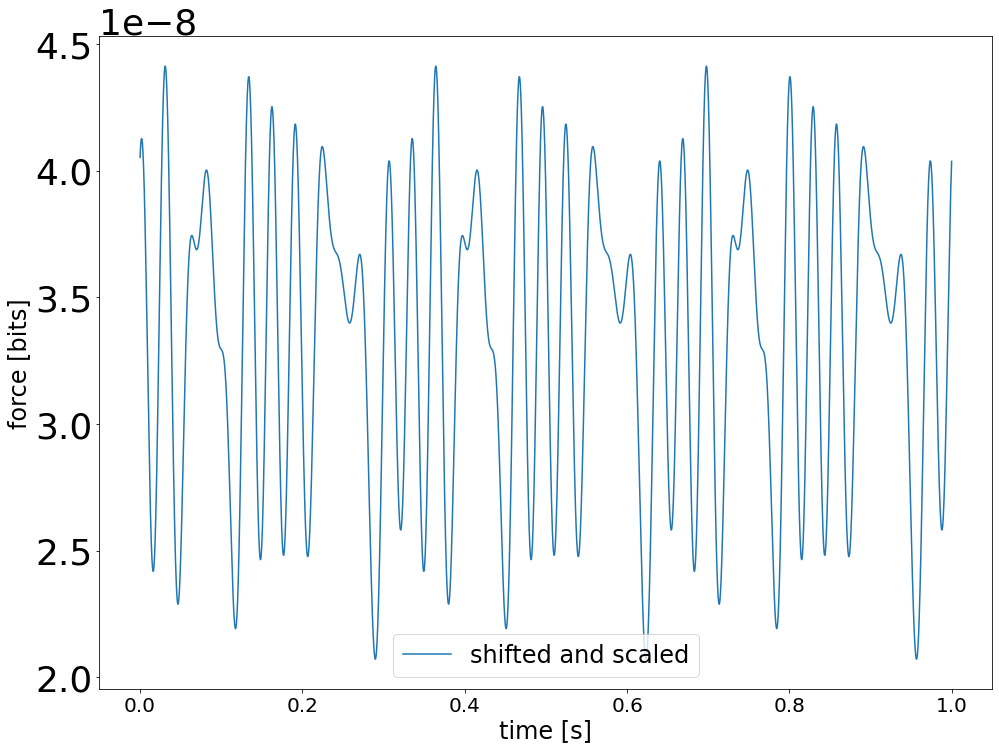

In [242]:
x = np.arange(0,1,1/5000)
#plt.plot(x,signal_sim[1] / np.mean(amplitude_scale), label="original")
#plt.plot(x,signal_sim_shift, label="shifted")
plt.plot(x,signal_sim_shift_scale,label="shifted and scaled")
#plt.plot(x,signal_sim_shift / np.mean(amplitude_scale),label="shifted and manually scaled",alpha=0.5) # 2 bits = 1 N



plt.xlabel("time [s]")
plt.ylabel("force [bits]")
plt.legend()
plt.show()

In [243]:
# extend to 10s
def repeat(arr, count):
    z_sig = []
    for i in range(count):
        z_sig.extend(arr)
    return z_sig

z_sig = repeat(signal_sim_shift_scale,10)
#z_sig2 = repeat(signal_sim_shift,10)

time_rep=np.arange(0,10,1/5000)


In [244]:
# transform amplitude according to scale
scale= 1e8 # according to alpha (Noise_add_3 = 1.2e9)
# 3.99023794e-20 from Nadav in time units?
factor = 1#1e-17 #e-17
#factor=1
z_trans_amp = np.divide(z_sig,factor)*scale

In [245]:
#def fft_norm(N, fsamp):
#    "Factor to normalize FFT to ASD units"
#    return np.sqrt(2 / (N * fsamp))
#freqs=np.linspace(0,int(5000/2),(int(len(z_trans_amp)/2))+1)    # change
#plt.plot(freqs,np.fft.rfft(z_trans_amp))

(0.0, 50000.0)

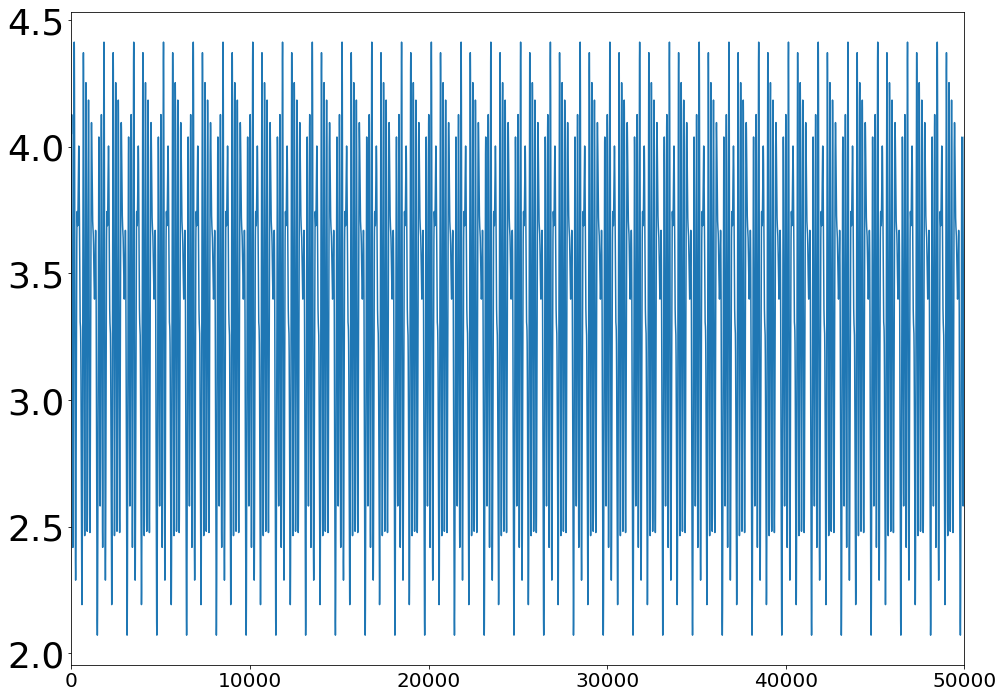

In [246]:
plt.plot(z_trans_amp)
#plt.plot(np.divide(signal_sim_shift,2e-17)*scale)
plt.xlim(0,50000)

In [228]:
### add noise or noise +bkg
with h5py.File('bck_noise.h5', 'r') as f_in:
    quad_data = np.array(f_in['quad_data'])
    data = quad_data.reshape(-1,12).T[9]
    z_sn = np.add(np.array(data),np.array(z_trans_amp))
    #z_sn = np.subtract(np.array(data),np.array(z_trans_amp))
    f_in.close()
    

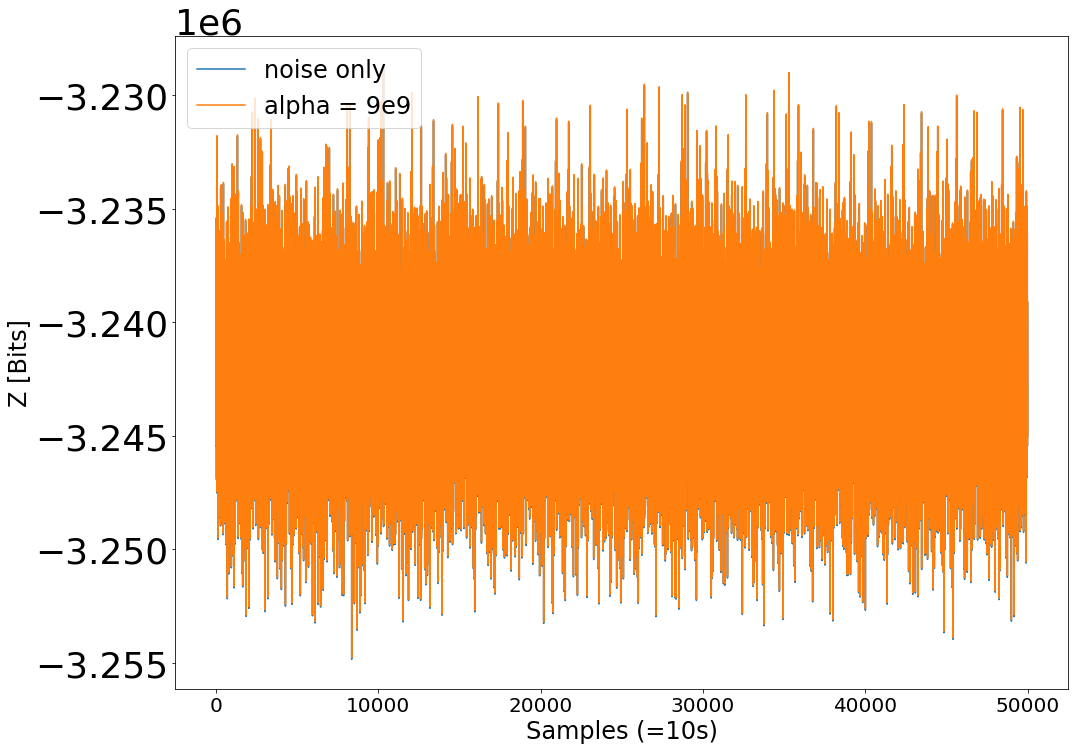

In [229]:
plt.plot(np.array(data), label="noise only")
plt.plot(np.array(z_sn),label="alpha = 9e9")
#plt.plot(np.array(z_sn2),alpha=0.5,label="alpha = 1e8")

plt.ylabel("Z [Bits]")
plt.xlabel("Samples (=10s)")
plt.legend()
plt.show()

In [230]:
from shutil import copyfile
in_dir = r"/data/new_trap_processed/mockfiles/Wilson/raw/noise/"
out_dir = r"/data/new_trap_processed/mockfiles/Wilson/output/noise/"

In [231]:
file_paths = []
for file_path in glob.iglob(in_dir+"*.h5"):
    file_paths.append(file_path)

In [232]:
i=0
for file_path in tqdm(file_paths):
    i+=1
    if(i<1001):
        with h5py.File(file_path, 'r') as f_in:
            quad_data_in = np.array(f_in['quad_data'])
            data_in = quad_data_in.reshape(-1,12).T[9]
            #plt.plot(np.array(data_in))
            z_sn = np.add(np.array(data_in),np.array(z_trans_amp))
            #z_sn = np.subtract(np.array(data_in),np.array(z_trans_amp))
            quad_data_in.reshape(-1,12).T[9] = z_sn
            f_in.close()
            #plt.plot(np.array(z_sn),color="black")
        out_path = out_dir + "Akio/" + "Noise_add_5_%d.h5" %(i-1)
        copyfile(src=file_path, dst=out_path)
        with h5py.File(out_path, 'r+') as f_out:
            del f_out['quad_data']
            f_out.create_dataset("quad_data", quad_data_in.shape,data=quad_data_in)
            f_out.close()
        # debugging by looking at out put file in loop
        #with h5py.File(output_file_path, 'r') as f_in2:
            #quad_data2 = np.array(f_in2['quad_data'])
            #data2 = quad_data2.reshape(-1,12).T[9]
            #plt.plot(data2,alpha=0.5,color="red")
            #plt.show()
            #f_in2.close()


100%|██████████| 1000/1000 [00:06<00:00, 143.87it/s]


In [988]:
# z sign?
